In [31]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import re

# --- Cài đặt cấu hình trực quan hóa ---
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 12

In [32]:
data = np.load(r'..\data\processed\processed_v1.npy', allow_pickle=True)
print(data)

[(1340539111971516416, 'Rachel Roh', '"La Crescenta-Montrose; CA"', '"Aggregator of Asian American news; scanning diverse sources 24/7/365. RT\'s; Follows and \'Likes\' will fuel me 👩\u200d💻"', '2009-04-08T17:52:46',    405, 1692, 3247, False, '2020-12-20T06:06:44', 'Same folks said daikon paste could treat a cytokine storm #PfizerBioNTech https://t.co/xeHhIMg1kF', "['PfizerBioNTech']", 'Twitter for Android', 0, 0, False, 369231238)
 (1338158543359250433, 'Albert Fong', '"San Francisco; CA"', '"Marketing dude; tech geek; heavy metal & \'80s music junkie. Fascinated by meteorology and all things in the cloud. Opinions are my own."', '2009-09-21T15:27:30',    834,  666,  178, False, '2020-12-13T16:27:13', '"While the world has been on the wrong side of history this year; hopefully; the biggest vaccination effort we\'ve ev… https://t.co/dlCHrZjkhm"', '', 'Twitter Web App', 1, 1, False, 354329983)
 (1337858199140118533, 'eli🇱🇹🇪🇺👌', 'Your Bed', '"heil; hydra 🖐☺"', '2020-06-25T23:30:28',    

In [33]:
print("Các kiểu dữ liệu của các cột")
data.dtype.descr

Các kiểu dữ liệu của các cột


[('id', '<i8'),
 ('user_name', '<U52'),
 ('user_location', '<U120'),
 ('user_description', '<U229'),
 ('user_created', '<M8[s]'),
 ('user_followers', '<i8'),
 ('user_friends', '<i8'),
 ('user_favourites', '<i8'),
 ('user_verified', '|b1'),
 ('date', '<M8[s]'),
 ('text', '<U156'),
 ('hashtags', '<U140'),
 ('source', '<U31'),
 ('retweets', '<i8'),
 ('favorites', '<i8'),
 ('is_retweet', '|b1'),
 ('acc_age', '<m8[s]')]

In [34]:
new_data = data.copy()

In [35]:
def process_hashtag(hashtag_string):
    if isinstance(hashtag_string, bytes):
        hashtag_string = hashtag_string.decode('utf-8')

    # chuyển chữ thường
    hashtag_string = hashtag_string.lower()

    # Loại bỏ các dấu
    hashtag_string = re.sub(r'[^\w\s]', '', hashtag_string)

    # Bỏ các khoảng trắng
    hashtag_string = re.sub(r'\s+', ' ', hashtag_string).strip()

    return hashtag_string


In [48]:
NO_HASHTAG = 'no_hashtag'
hashtag_col = new_data['hashtags']
processed_hashtags = []
draw_hashtags = []

all_tags_list = []

for tag_string in hashtag_col:

    if not tag_string.strip() or tag_string == NO_HASHTAG :
        processed_hashtags.append(NO_HASHTAG)
        continue

    cleaned_string = process_hashtag(tag_string)
    processed_hashtags.append(cleaned_string)
    draw_hashtags.append(cleaned_string)


new_data['hashtags'] = np.array(processed_hashtags, dtype=object)


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_20928\1075093428.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=counts, y=labels, palette='viridis')


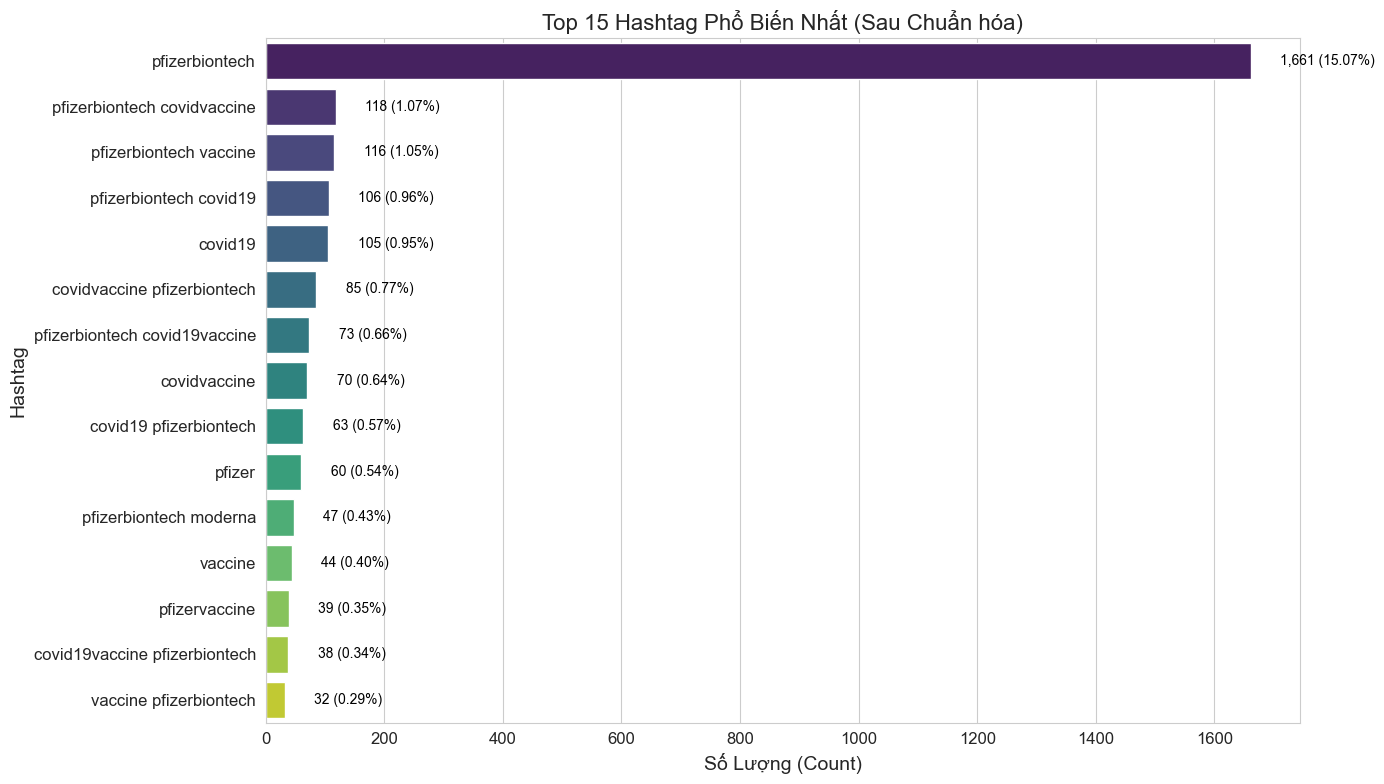

In [54]:
hashtag_col = new_data['hashtags']
total_rows = len(new_data)


# Đếm tần suất
word_counter = Counter(draw_hashtags)
top_15_hashtags = word_counter.most_common(15)

# Tách nhãn và số lượng
labels = [tag[0] for tag in top_15_hashtags]
counts = [tag[1] for tag in top_15_hashtags]


plt.figure(figsize=(14, 8))
ax = sns.barplot(x=counts, y=labels, palette='viridis')

# Thêm chú thích số liệu
for i, count in enumerate(counts):
    percentage = (count / total_rows) * 100
    text = f'{count:,.0f} ({percentage:.2f}%)' 
    ax.text(count + 50, i, text, color='black', ha='left', va='center', fontsize=10)

plt.title('Top 15 Hashtag Phổ Biến Nhất (Sau Chuẩn hóa)', fontsize=16)
plt.xlabel('Số Lượng (Count)', fontsize=14)
plt.ylabel('Hashtag', fontsize=14)
plt.tight_layout()
plt.show()

In [38]:
new_data['user_location'][:20]

array(['"La Crescenta-Montrose; CA"', '"San Francisco; CA"', 'Your Bed',
       '"Vancouver; BC - Canada"', '', '"Birmingham; England"',
       '"Austria; Ukraine and Kosovo"', '', '', 'Islamabad',
       'Turkey-Israel', '', 'India', '', '', '"London; England"',
       'Global', 'Türkiye', '"Bristol; UK"', '"Los Angeles; CA"'],
      dtype='<U120')

In [56]:


IMPUTE_VALUE = 'unknown_location'
location_col_raw = new_data['user_location']

# Dictionary ánh xạ phức tạp
COMPREHENSIVE_MAPPING = {
    # Ưu tiên các từ viết tắt và khu vực lớn nhất để nhóm về USA
    'usa': 'usa', 'united states': 'usa', 'california': 'usa', 'new york': 'usa', 'texas': 'usa', 
    'ny': 'usa', 'tx': 'usa', 'fl': 'usa', 'pa': 'usa', 'nj': 'usa', 'ca': 'usa', 'dc': 'usa', 
    'ga': 'usa', 'il': 'usa', 'wa': 'usa', 'nc': 'usa', 'oh': 'usa', 'mo': 'usa', 'az': 'usa',
    'los angeles': 'usa',
    
    # Vương quốc Anh/Châu Âu
    'uk': 'united kingdom', 'england': 'united kingdom', 'london': 'united kingdom', 
    'scotland': 'united kingdom', 'wales': 'united kingdom', 'ireland': 'ireland',
    'germany': 'germany', 'france': 'france', 'europe': 'europe',  'glasgow environs': 'united kingdom',  
    
    # Châu Á/UAE/Canada
    'india': 'india', 'mumbai': 'india', 'delhi': 'india', 'kolkata': 'india', 'chennai': 'india',
    'uae': 'united arab emirates', 'dubai': 'united arab emirates', 'abu dhabi': 'united arab emirates',
    'canada': 'canada', 'toronto': 'canada', 'ontario': 'canada', 'montreal': 'canada',
    'malaysia': 'malaysia', 'petaling jaya': 'malaysia', 'singapore': 'singapore', 'hong kong': 'hong kong',
    
    # Global/Others
    'global': 'global', 'earth': 'global', 'worldwide': 'global', 'n/a': IMPUTE_VALUE,
    'unknown': IMPUTE_VALUE 
                    
  
}

# Hàm Substring Match
def improved_location_mapper(normalized_location, mapping_dict):
    loc_lower = normalized_location.strip()
    
    for key_part, standardized_region in mapping_dict.items():
        # Chỉ khớp các từ khóa có độ dài > 1
        if len(key_part) > 1 and key_part in loc_lower:
            return standardized_region 
    
    # Nếu không khớp, giữ nguyên chuỗi đã được làm sạch
    return loc_lower

# 1. Normalization Sơ bộ (Lowercasing, Imputation, Clean Symbols)
location_col_normalized = np.array([
    IMPUTE_VALUE if not str(loc).strip() else str(loc).lower()
    for loc in location_col_raw
], dtype=object)

location_col_normalized = np.char.replace(location_col_normalized.astype(str), ';', ',')
location_col_normalized = np.char.replace(location_col_normalized, '"', '')
location_col_normalized = np.char.replace(location_col_normalized, "'", '')
location_col_normalized = np.array([
    re.sub(r'[^\w\s,]', '', loc).strip() for loc in location_col_normalized
], dtype=object)


# 2. Áp dụng Substring Mapping lên toàn bộ mảng
final_locations = np.array([
    IMPUTE_VALUE if not str(loc).strip() else str(loc).lower()
    for loc in location_col_normalized
], dtype=object)

new_data['user_location'] = final_locations




In [ ]:
# Thống kê tần suất
unique_final, counts_final = np.unique(final_locations, return_counts=True)
sorted_indices = np.argsort(counts_final)[::-1]
top_labels = unique_final[sorted_indices[:15]]
top_counts = counts_final[sorted_indices[:15]]
total_rows = len(final_locations)

print("--- Thống kê Top 15 Vị Trí ---")
print(f"{'Vị Trí':<30}{'Số Lượng (Count)':>18}{'Tỉ Lệ (%)':>15}")
print("-" * 63)

for label, count in zip(top_labels, top_counts):
    percentage = (count / total_rows) * 100
    print(f"{label:<30}{count:>18,}{percentage:>14.2f}%")


--- Thống kê Top 15 Vị Trí (Sau Ánh xạ Cuối cùng) ---
Vị Trí                          Số Lượng (Count)      Tỉ Lệ (%)
---------------------------------------------------------------
usa                                        5,782         52.47%
united kingdom                             1,028          9.33%
india                                        432          3.92%
malaysia                                     308          2.79%
united arab emirates                         221          2.01%
ireland                                      180          1.63%
global                                       162          1.47%
canada                                       117          1.06%
hong kong                                     88          0.80%
unknown_location                              61          0.55%
europe                                        60          0.54%
ragbag of reviews and insights                49          0.44%
keepfightingmichael                           45  

In [40]:
print(new_data['user_location'][:20])

['usa' 'usa' 'your bed' 'usa' 'usa' 'united kingdom' 'united kingdom'
 'usa' 'usa' 'islamabad' 'turkeyisrael' 'usa' 'india' 'usa' 'usa'
 'united kingdom' 'global' 'türkiye' 'united kingdom' 'usa']


In [41]:

# Danh sách các stop word 
STOP_WORDS = set([
    'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're",
    'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 
    'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 
    'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 
    'whom', 'this', 'that', "that'll", 'these', 'those', 'is', 'are', 'was', 
    'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 
    'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 
    'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 
    'about', 'against', 'between', 'into', 'through', 'during', 'before', 
    'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 
    'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 
    'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 
    'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 
    'only', 'own', 'same', 'so', 'than', 'too', 'very', 's', 't', 'can', 
    'will', 'just', 'don', "don't", 'should', "should've", 'now', 'amp', '\'s', 've'
])


def process_text(text):
    if isinstance(text, bytes):
        text = text.decode('utf-8')
    
    # chuyển chữ thường
    text = text.lower()

    # Xoá newline
    text = re.sub(r'\s+', ' ', text).strip()
    
    # Xóa URL
    text = re.sub(r"https\S+|www\S+|http\S+", '', text, flags=re.MULTILINE)
    
    # Xóa @mentions và hashtag
    text = re.sub(r'@\w+|\#', '', text)
    # Xóa ký tự xuống dòng (\n, \r)
    text = re.sub(r'\\n', '', text)
    
    # Xóa dấu câu và ký tự không phải chữ/số
    text = re.sub(r'[^\w\s]', ' ', text)
    
    # Xoá số 

    text = re.sub(r'\b\d+\b', '', text)
    # Xoá html tag
    text = re.sub(r'<.*?>', '', text)
    
    # Tách từ
    text_tokens = text.split()
    
    # Loại bỏ stop words
    filtered_text = [w for w in text_tokens if w not in STOP_WORDS]
    
    return " ".join(filtered_text)

In [42]:
text_col = new_data['text']

processed_text_list = [
    process_text(t) 
    for t in text_col
]

processed_text_array = np.array(processed_text_list, dtype=object)

new_data['text'] = processed_text_array 




In [43]:
# --- KIỂM TRA MỘT SỐ DÒNG ĐẦU ---
print("\n5 Tweet đầu tiên sau khi làm sạch:")
print(new_data['text'][:5])


5 Tweet đầu tiên sau khi làm sạch:
['folks said daikon paste could treat cytokine storm pfizerbiontech'
 'world wrong side history year hopefully biggest vaccination effort ev'
 'coronavirus sputnikv astrazeneca pfizerbiontech moderna covid_19 russian vaccine created last years'
 'facts immutable senator even re ethically sturdy enough acknowledge born'
 'explain need vaccine whereareallthesickpeople pfizerbiontech']
